In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y_All=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
y_All=y_All/25.0

In [4]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')

In [5]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [7]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [8]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [9]:
# AO Input
AOData1 = xr.open_dataset('../../../Data/AO_EU/AO_Calculated.nc')
print(AOData1)

Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(AOData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), AOData1.AO[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

<xarray.Dataset>
Dimensions:  (time: 3772)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Data variables:
    AO       (time) float32 ...


In [10]:
#EU Input
EUData1 = xr.open_dataset('../../../Data/AO_EU/EU_NovDecJan.nc')
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(EUData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), EUData1.EUVal[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

In [11]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)
ao=AOData.AO.shift(time=1)
eu=EUData.EU.shift(time=1)

In [12]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
aoTsAll=ao[((ao.time.dt.month>11) | (ao.time.dt.month<2)) & (ao.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
euTsAll=eu[((eu.time.dt.month>11) | (eu.time.dt.month<2)) & (eu.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [13]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=aoTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
aoTsAll.values=t1.unstack()

t1=euTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
euTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [14]:
t2mAll=t2mTsAll.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTsAll.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTsAll.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTsAll.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTsAll.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTsAll.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape

aoAll=aoTsAll.values
aoAll=aoAll[:,:,:,None]
aoAll.shape

euAll=euTsAll.values
euAll=euAll[:,:,:,None]
euAll.shape

(2418, 18, 26, 1)

In [15]:
yAll=y_All.values
yAll=yAll[:,None]
yAll.shape

(2418, 1)

In [16]:
XAll=np.array([rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])

XAll_reshape = np.einsum('lkija->klija',XAll)
XAll_reshape.shape


(2418, 7, 18, 26, 1)

In [17]:
X_train,X_test,y_train,y_test= train_test_split(XAll_reshape ,yAll,test_size=0.20, random_state=0)

In [18]:
Xtrain,XVal,ytrain,yVal= train_test_split(X_train ,y_train,test_size=0.20, random_state=50)

In [19]:
######## First let use choose best architecture using following 6 ways

In [20]:
#  LeNet-5 

Epoch 1/20
49/49 [==============================] - 8s 135ms/step - loss: 0.2861 - accuracy: 0.0461 - val_loss: 0.1841 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 6s 123ms/step - loss: 0.1673 - accuracy: 0.0591 - val_loss: 0.1601 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 6s 126ms/step - loss: 0.1399 - accuracy: 0.0676 - val_loss: 0.1302 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 6s 124ms/step - loss: 0.1183 - accuracy: 0.0581 - val_loss: 0.1261 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 6s 127ms/step - loss: 0.1054 - accuracy: 0.0509 - val_loss: 0.1137 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 6s 127ms/step - loss: 0.0999 - accuracy: 0.0468 - val_loss: 0.1099 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 6s 126ms/step - loss: 0.0919 - accuracy: 0.0500 - val_loss: 0.1067 - val_accuracy: 0.0336
Epoch 

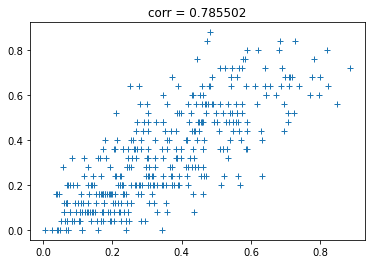

In [21]:
cnn1 = Sequential()
cnn1.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn1.add(MaxPooling3D(pool_size=2,padding='same'))
cnn1.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
cnn1.add(MaxPooling3D(pool_size=2,padding='same'))

cnn1.add(Flatten())

cnn1.add(Dense(120, activation='relu'))
cnn1.add(Dense(84, activation='relu'))
cnn1.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn1.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn1.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn1.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn1.summary()




Epoch 1/20
49/49 [==============================] - 2s 32ms/step - loss: 0.1863 - accuracy: 0.0521 - val_loss: 0.1704 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 1s 26ms/step - loss: 0.1550 - accuracy: 0.0660 - val_loss: 0.1429 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.1352 - accuracy: 0.0583 - val_loss: 0.1215 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 1s 28ms/step - loss: 0.1133 - accuracy: 0.0615 - val_loss: 0.1215 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 1s 27ms/step - loss: 0.1043 - accuracy: 0.0508 - val_loss: 0.1087 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.0969 - accuracy: 0.0548 - val_loss: 0.1111 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.0945 - accuracy: 0.0631 - val_loss: 0.1070 - val_accuracy: 0.0336
Epoch 8/20
49

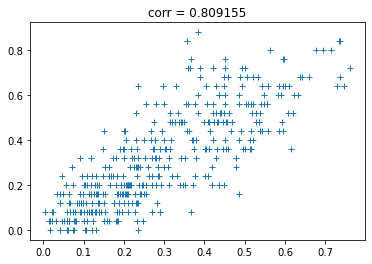

In [22]:
cnn2 = Sequential()
cnn2.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn2.add(AveragePooling3D(pool_size=2,padding='same'))
cnn2.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
cnn2.add(AveragePooling3D(pool_size=2,padding='same'))

cnn2.add(Flatten())

cnn2.add(Dense(120, activation='relu'))
cnn2.add(Dense(84, activation='relu'))
cnn2.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn2.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn2.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn2.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn2.summary()

In [23]:
# Conv-Pool-Conv-Pool kind of architecture with doubling the number of filters every stage

Epoch 1/20
49/49 [==============================] - 23s 456ms/step - loss: 0.3158 - accuracy: 0.0523 - val_loss: 0.1837 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 22s 458ms/step - loss: 0.1617 - accuracy: 0.0536 - val_loss: 0.1552 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 22s 456ms/step - loss: 0.1441 - accuracy: 0.0606 - val_loss: 0.1420 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 22s 457ms/step - loss: 0.1207 - accuracy: 0.0564 - val_loss: 0.1171 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 22s 454ms/step - loss: 0.1051 - accuracy: 0.0664 - val_loss: 0.1124 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 22s 452ms/step - loss: 0.0949 - accuracy: 0.0580 - val_loss: 0.1133 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 22s 458ms/step - loss: 0.0868 - accuracy: 0.0494 - val_loss: 0.1041 - val_accuracy: 0.0336

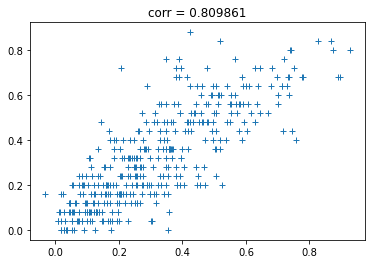

In [24]:
cnn3 = Sequential()
cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
cnn3.add(MaxPooling3D(pool_size=2,padding='same'))

cnn3.add(Flatten())

cnn3.add(Dense(64, activation='relu'))
cnn3.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn3.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn3.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn3.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn3.summary()

Epoch 1/20
49/49 [==============================] - 3s 53ms/step - loss: 0.1958 - accuracy: 0.0548 - val_loss: 0.1802 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 2s 50ms/step - loss: 0.1747 - accuracy: 0.0587 - val_loss: 0.1797 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 2s 50ms/step - loss: 0.1568 - accuracy: 0.0515 - val_loss: 0.1447 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 2s 51ms/step - loss: 0.1396 - accuracy: 0.0517 - val_loss: 0.1306 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 2s 50ms/step - loss: 0.1133 - accuracy: 0.0482 - val_loss: 0.1378 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 2s 50ms/step - loss: 0.1092 - accuracy: 0.0596 - val_loss: 0.1117 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 2s 51ms/step - loss: 0.0944 - accuracy: 0.0554 - val_loss: 0.1104 - val_accuracy: 0.0336
Epoch 8/20
49

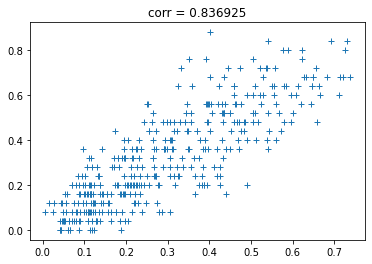

In [25]:
cnn4 = Sequential()
cnn4.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
cnn4.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
cnn4.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
cnn4.add(AveragePooling3D(pool_size=2,padding='same'))

cnn4.add(Flatten())

cnn4.add(Dense(64, activation='relu'))
cnn4.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn4.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn4.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn4.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn4.summary()

In [26]:
# a vgg like model with the trend Conv-Conv-Pool-Conv-Conv-Pool

Epoch 1/20
49/49 [==============================] - 14s 274ms/step - loss: 0.4576 - accuracy: 0.0571 - val_loss: 0.1802 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 13s 271ms/step - loss: 0.1736 - accuracy: 0.0584 - val_loss: 0.1682 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 13s 274ms/step - loss: 0.1428 - accuracy: 0.0622 - val_loss: 0.1403 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 13s 272ms/step - loss: 0.1142 - accuracy: 0.0509 - val_loss: 0.1136 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 13s 271ms/step - loss: 0.1075 - accuracy: 0.0638 - val_loss: 0.1182 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 13s 267ms/step - loss: 0.0930 - accuracy: 0.0478 - val_loss: 0.1012 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 13s 267ms/step - loss: 0.0824 - accuracy: 0.0523 - val_loss: 0.1001 - val_accuracy: 0.0336

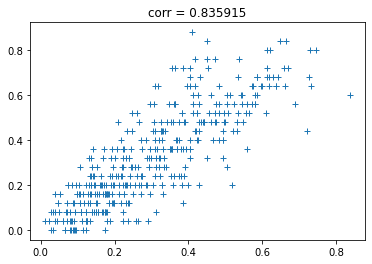

In [27]:
cnn5 = Sequential()
cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
cnn5.add(MaxPooling3D(pool_size=2,padding='same'))


cnn5.add(Flatten())

cnn5.add(Dense(512, activation='relu'))
cnn5.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn5.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn5.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn5.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn5.summary()

Epoch 1/20
49/49 [==============================] - 4s 82ms/step - loss: 0.2350 - accuracy: 0.0492 - val_loss: 0.1831 - val_accuracy: 0.0336
Epoch 2/20
49/49 [==============================] - 4s 80ms/step - loss: 0.1729 - accuracy: 0.0631 - val_loss: 0.1781 - val_accuracy: 0.0336
Epoch 3/20
49/49 [==============================] - 4s 79ms/step - loss: 0.1715 - accuracy: 0.0535 - val_loss: 0.1695 - val_accuracy: 0.0336
Epoch 4/20
49/49 [==============================] - 4s 80ms/step - loss: 0.1486 - accuracy: 0.0622 - val_loss: 0.1202 - val_accuracy: 0.0336
Epoch 5/20
49/49 [==============================] - 4s 80ms/step - loss: 0.1120 - accuracy: 0.0543 - val_loss: 0.1105 - val_accuracy: 0.0336
Epoch 6/20
49/49 [==============================] - 4s 79ms/step - loss: 0.0987 - accuracy: 0.0494 - val_loss: 0.1145 - val_accuracy: 0.0336
Epoch 7/20
49/49 [==============================] - 4s 79ms/step - loss: 0.0897 - accuracy: 0.0490 - val_loss: 0.1019 - val_accuracy: 0.0336
Epoch 8/20
49

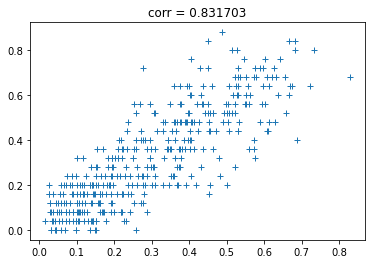

In [28]:
cnn6 = Sequential()
cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(Xtrain.shape[1],Xtrain.shape[2],Xtrain.shape[3],1)),)
cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
cnn6.add(AveragePooling3D(pool_size=2,padding='same'))


cnn6.add(Flatten())

cnn6.add(Dense(512, activation='relu'))
cnn6.add(Dense(units=1, activation = 'linear'))

adam = keras.optimizers.Adam(lr=0.001)
cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
history = cnn6.fit(Xtrain, ytrain, validation_data=(XVal, yVal), epochs=20)
yy_test = cnn6.predict(XVal)

test_corr = np.corrcoef(yy_test[:,0],yVal[:,0])[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,yVal,'+')
cnn6.summary()